Notes about how to condition and process the HAT-P-37 data

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile
from astropy.units import Quantity

# From https://ui.adsabs.harvard.edu/abs/2023ApJS..265....4K/abstract
orbital_period = 2.79744256 #±0.00000041 

In [3]:
# Check which lightcurves are available for HAT-P-37
# I can't seem to look the system up except by its TIC number
# exptime='short' only keeps the 120-s exposures
search_result = lk.search_lightcurve("TIC 267572272", author='SPOC', exptime='short')
search_result
tess_lc_collection = search_result.download_all()  # changed name of variable to make it easier to identify
print(tess_lc_collection)

# LightCurveCollection of 11 objects:
#     0: <TessLightCurve LABEL="TIC 267572272" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     1: <TessLightCurve LABEL="TIC 267572272" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     2: <TessLightCurve LABEL="TIC 267572272" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     3: <TessLightCurve LABEL="TIC 267572272" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     4: <TessLightCurve LABEL="TIC 267572272" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     5: <TessLightCurve LABEL="TIC 267572272" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     6: <TessLightCurve LABEL="TIC 267572272" SECTOR=59 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     7: <TessLightCurve LABEL="TIC 267572272" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     8: <TessLightCurve LABEL="TIC 267572272" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     9: <TessLightCurve LABEL="TIC 267572272" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     10: <TessLightCurve LABEL="TIC 267572272" SECTOR=82 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

LightCurveCollection of 11 objects:
    0: <TessLightCurve LABEL="TIC 267572272" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 267572272" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 267572272" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 267572272" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 267572272" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 267572272" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 267572272" SECTOR=59 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 267572272" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 267572272" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 267572272" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 267572272

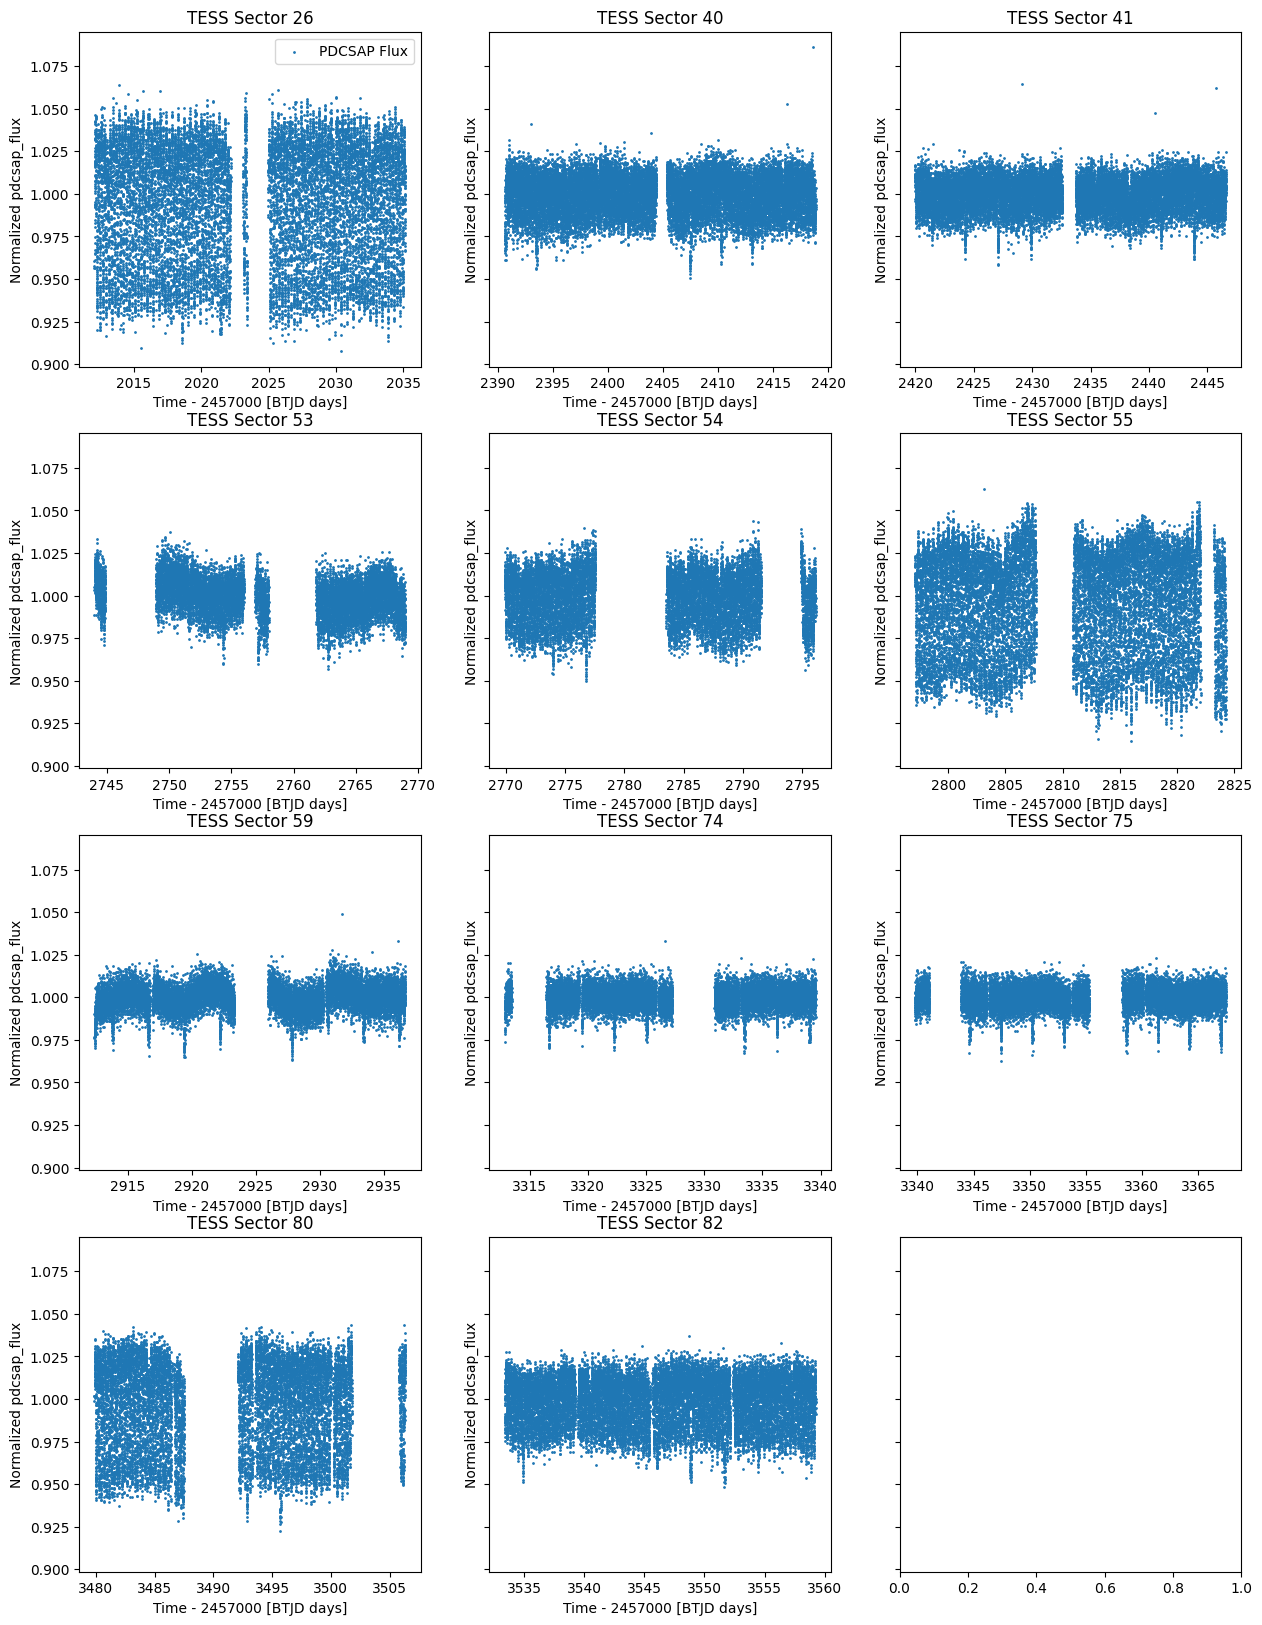

In [4]:
# PDCSAP_FLUX is the mission's estimate for lightcurve with instrument effects taken out
# We can compare the PDCSAP flux to the SAP flux (Simple Apeture Photometry) using the following:
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharey="all") # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
for i, lc in enumerate(tess_lc_collection):
    tess_lc_collection[i].scatter(column='pdcsap_flux', label='PDCSAP Flux', normalize=True, ax=axs[ax_indices[i]])
    # lc.plot(column='sap_flux', normalize=True, ax=axs[0])
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
    if i == 0:
        axs[ax_indices[i]].legend()  # keep the legend in the first plot
    else:
        axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.

# klc.plot(column='sap_flux', label='SAP Flux', normalize=True, ax=ax);

# ax = tess_lc_collection.plot(normalize=True)
# ax.get_legend().remove()


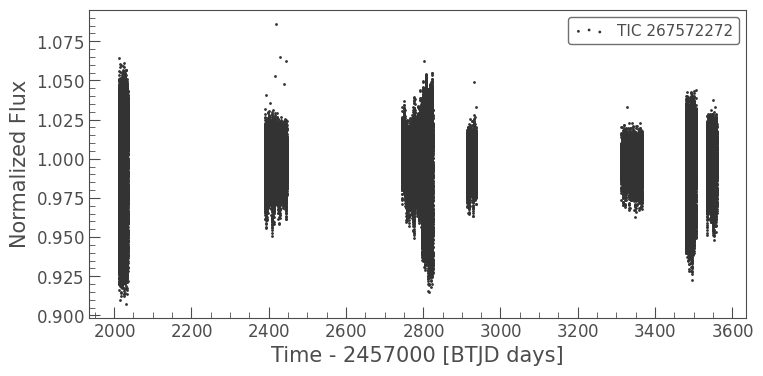

In [5]:
# Make a single lightcurve out of the collection of lightcurves
composite_lc = tess_lc_collection.stitch()
composite_lc.scatter();


Composite period:  0.21773270629361255 d
Composite EB:  0.4354654125872251 d


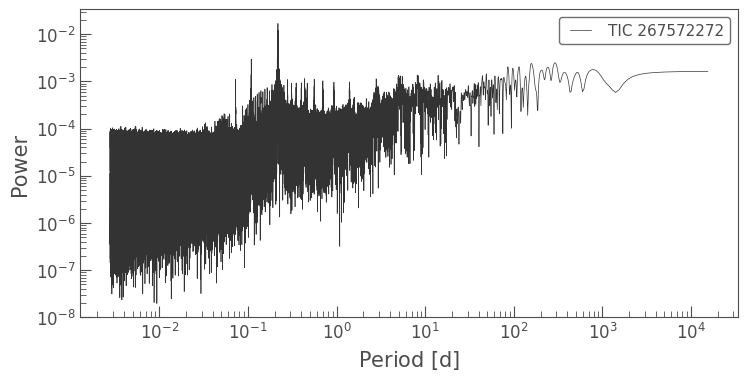

In [56]:
# Calculate periodogram using ALL(?) the light curves  - includes "misbehaved" sectors
composite_pg = composite_lc.to_periodogram(oversample_factor=10)
ax = composite_pg.plot(view='period', scale='log');
# Find peak - 0.21769631036042894 d
# 
# BUT we know that this signal is due to an eclipsing binary, so we should have two eclipses per orbit,
# so we need to fold on twice on the period
composite_average = composite_pg.period_at_max_power
composite_EB_period = 2.* composite_average
print("Composite period: ", composite_average)
print("Composite EB: ", composite_EB_period)

In [55]:
# calculate the t0 for the eclipsing binary (from https://iopscience.iop.org/article/10.3847/1538-4365/ab9cae#apjsab9caes5)
HJD_shift = 2400000.5
EB_t0_HJD = 58641.4289616 + HJD_shift
# print(EB_t0_HJD)
EB_t0_BJD = 2458641.929750  # calculated using the Ohio State Applet (https://astroutils.astronomy.osu.edu/time/hjd2bjd.html)
# finally convert t0 to TESS BJD (BTJD)
EB_t0_BTJD = EB_t0_BJD - 2457000.
print(EB_t0_BTJD)

1641.9297500001267


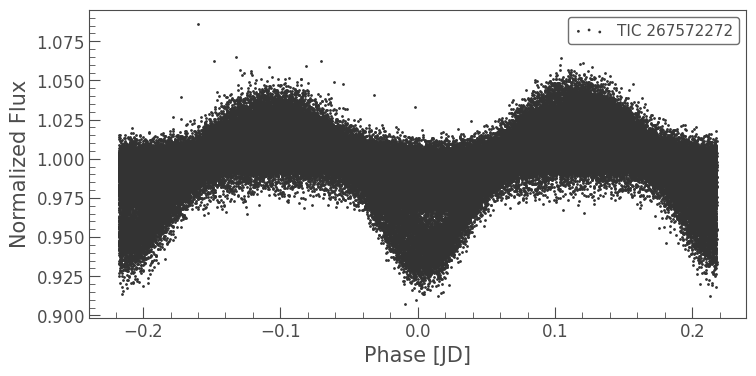

In [ ]:
# plot the phase folded data using the peak of the periodogram of the composite light curve (ie ALL the sectors together)
# big_lc.fold(period=2.*average_period).scatter();
folded_composite_lc = composite_lc.fold(period=composite_EB_period, epoch_time=EB_t0_BTJD)  # folded at 0.4354654125872251 d
folded_composite_lc.scatter();

Folding at this period is not correctly capturing the Eclipsing Binary (EB)... we will instead calculate the LS for each sector and use the average to fold the data

/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/.hat37-env/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0.98, 'EB period = 0.43541546498233497 d using 9.0 Sectors')

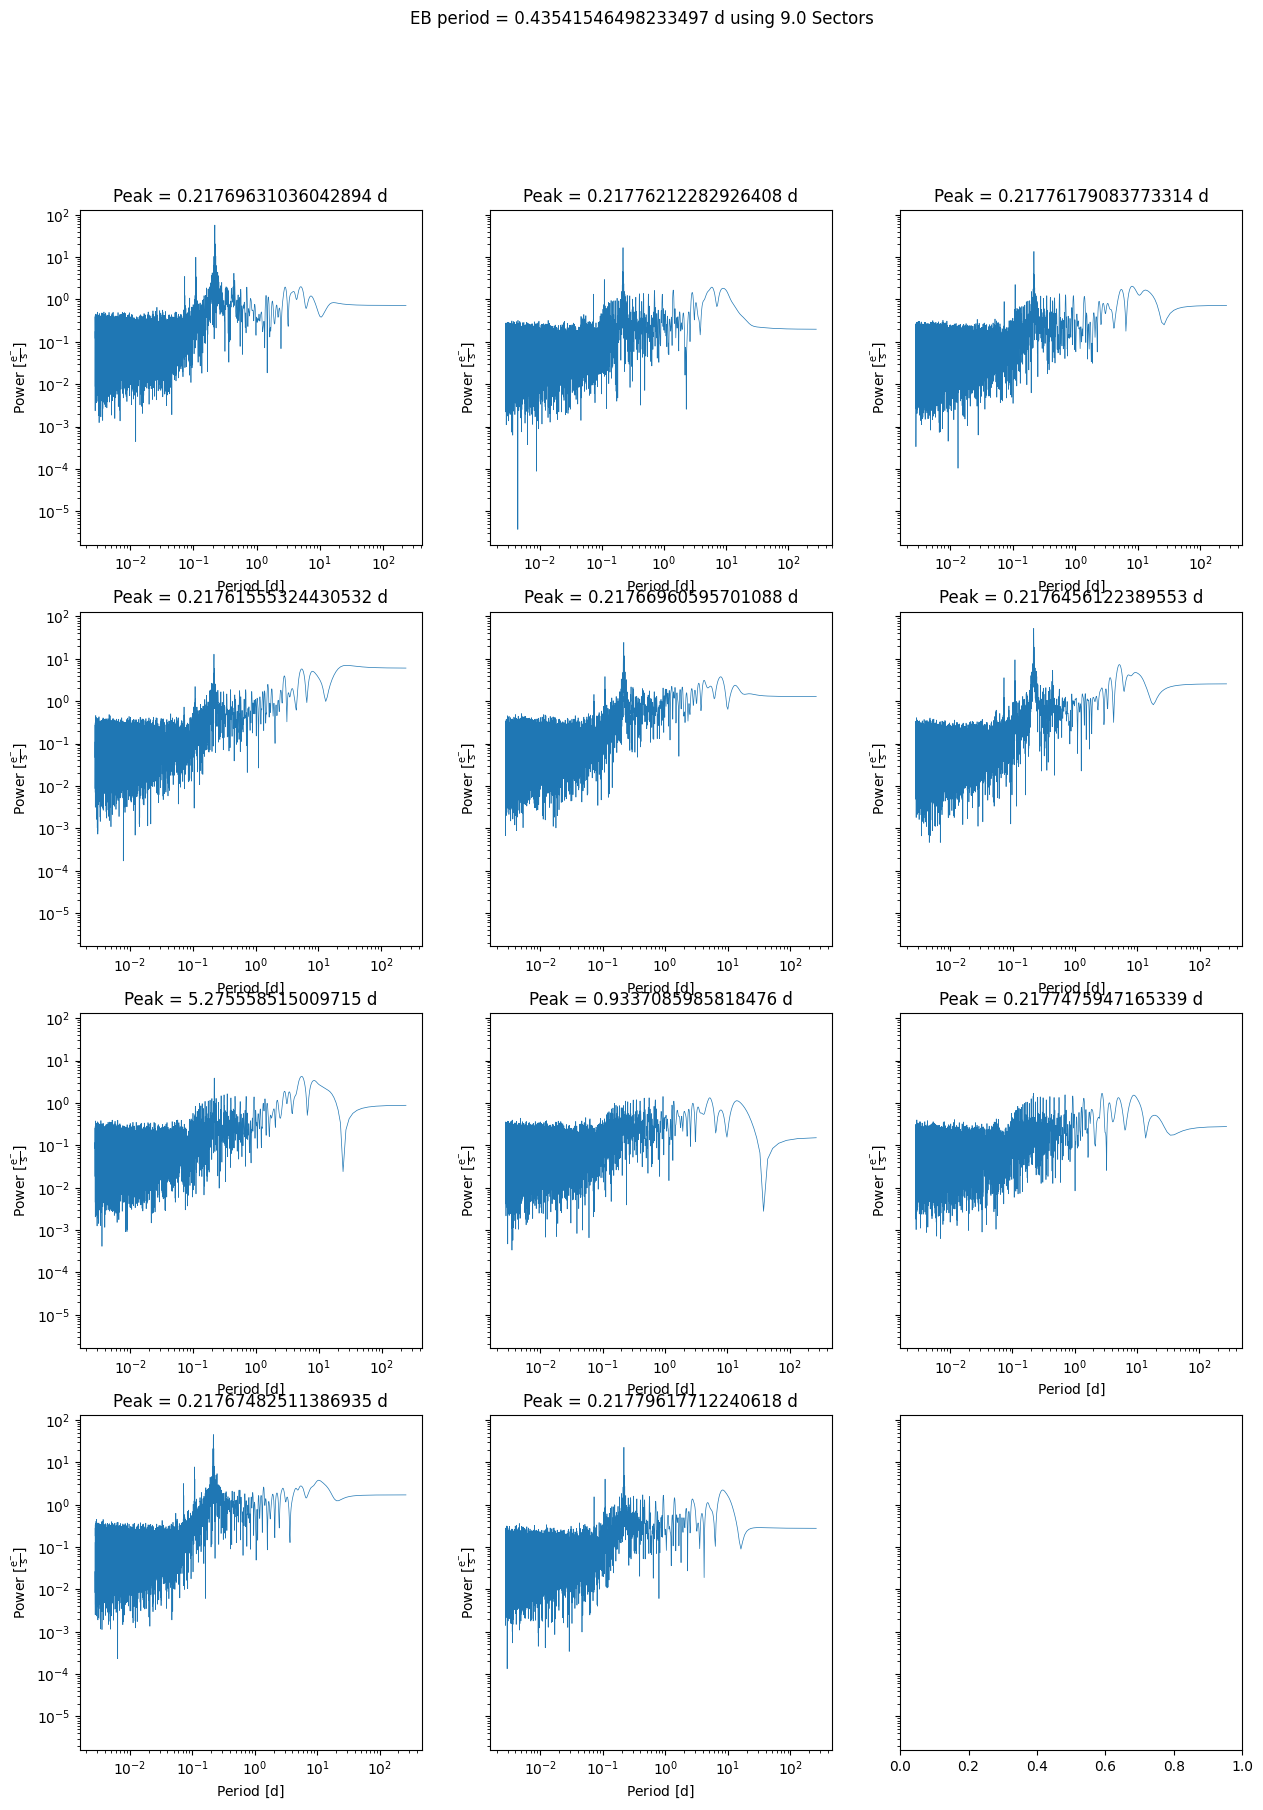

In [68]:
# Use the PDCSAP to calculate the LS for each sector of TESS data and plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharey="all") # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
average_period = 0
num_sectors_used = 0
for i, lc in enumerate([*tess_lc_collection]):
    pg = lc.to_periodogram(oversample_factor=10)
    pg.plot(view='period', scale='log', ax=axs[ax_indices[i]])
    axs[ax_indices[i]].set_title(f"Peak = {pg.period_at_max_power}")
    axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.
    
    if pg.period_at_max_power >= Quantity(0.4, "day"):  # do not include poorly-behaved data (i.e. sectors 59 & 74)
        pass
    else:
        average_period += pg.period_at_max_power
        num_sectors_used += 1.
# after calculating the peakfor each sector, divde by number of sectors to get the average period
average_period /= num_sectors_used 

# periods for each sector (4/7 - BJ)
# 0 26 0.21769631036042894 d
# 1 40 0.21776212282926408 d
# 2 41 0.21776179083773314 d
# 3 53 0.21761555324430532 d
# 4 54 0.21766960595701088 d
# 5 55 0.2176456122389553 d
# 6 59 5.275558515009715 d
# 7 74 0.9337085985818474 d
# 8 75 0.2177475947165339 d
# 9 80 0.21767482511386935 d
# 10 82 0.21779617712240618 d

# BUT we know that this signal is due to an eclipsing binary, so we should have two eclipses per orbit,
# so we need to fold on twice on the period
LS_EB_period = average_period * 2.
fig.suptitle(f"EB period = {LS_EB_period} using {num_sectors_used} Sectors")

/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/.hat37-env/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


26 0.21769631036042894 d
40 0.21776212282926408 d
41 0.21776179083773314 d
53 0.21761555324430532 d
54 0.21766960595701088 d
55 0.2176456122389553 d
75 0.2177475947165339 d
80 0.21767482511386935 d
82 0.21779617712240618 d
9
average period:  0.21770773249116748 d
EB period:  0.43541546498233497 d


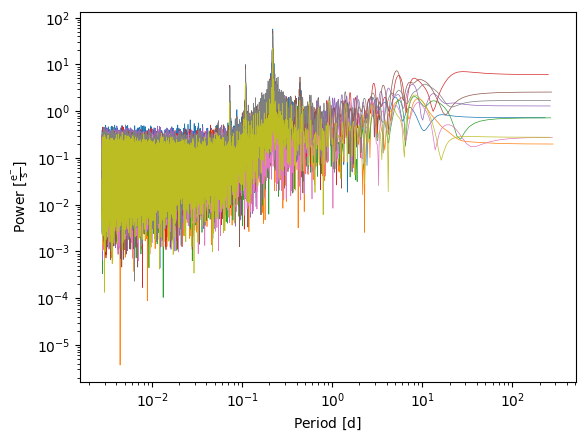

In [69]:
# DO NOT run this cell & the cell above, they result in the same average period, just a matter of viewing preference
# OPTIONAL: Plot all periodograms on the same set of axes removing bad sectors first (BJ-4/7)

fig = plt.figure()
ax = fig.add_subplot(111)

# Sectors 59 and 74 show an anomalous peak at long periods, so we'll mask them out for the purposes of estimating the period.
average_period = 0.
wellbehaving_list = [*tess_lc_collection[:6], *tess_lc_collection[8:]]  # (4/8 RH) Changed index from 5 to 6, python indexing is NON-inclusive and we threw out too many sectors (3 instead of two)
for cur_lc in wellbehaving_list:

    # We'll focus on the SAP flux because it has the least processing.
    cur_lc.select_flux("pdcsap_flux")

    # Calculate periodogram
    pg = cur_lc.to_periodogram(oversample_factor=10) 
    # help(big_lc.to_periodogram)
    pg.plot(view='period', scale='log', ax=ax);
    # Find peak - 0.21769631036042894 d
    # 
    # BUT we know that this signal is due to an eclipsing binary, so we should have two eclipses per orbit,
    # so we need to fold on twice on the period
    print(cur_lc.sector, pg.period_at_max_power)

    average_period += pg.period_at_max_power

average_period /= len(wellbehaving_list)
print(len(wellbehaving_list))
print(f"average period: ", average_period)
print(f"EB period: ", 2.*average_period)

# ax.set_xlim([1e-1, 1e0])
ax.get_legend().remove()
ax.set_yscale('log')



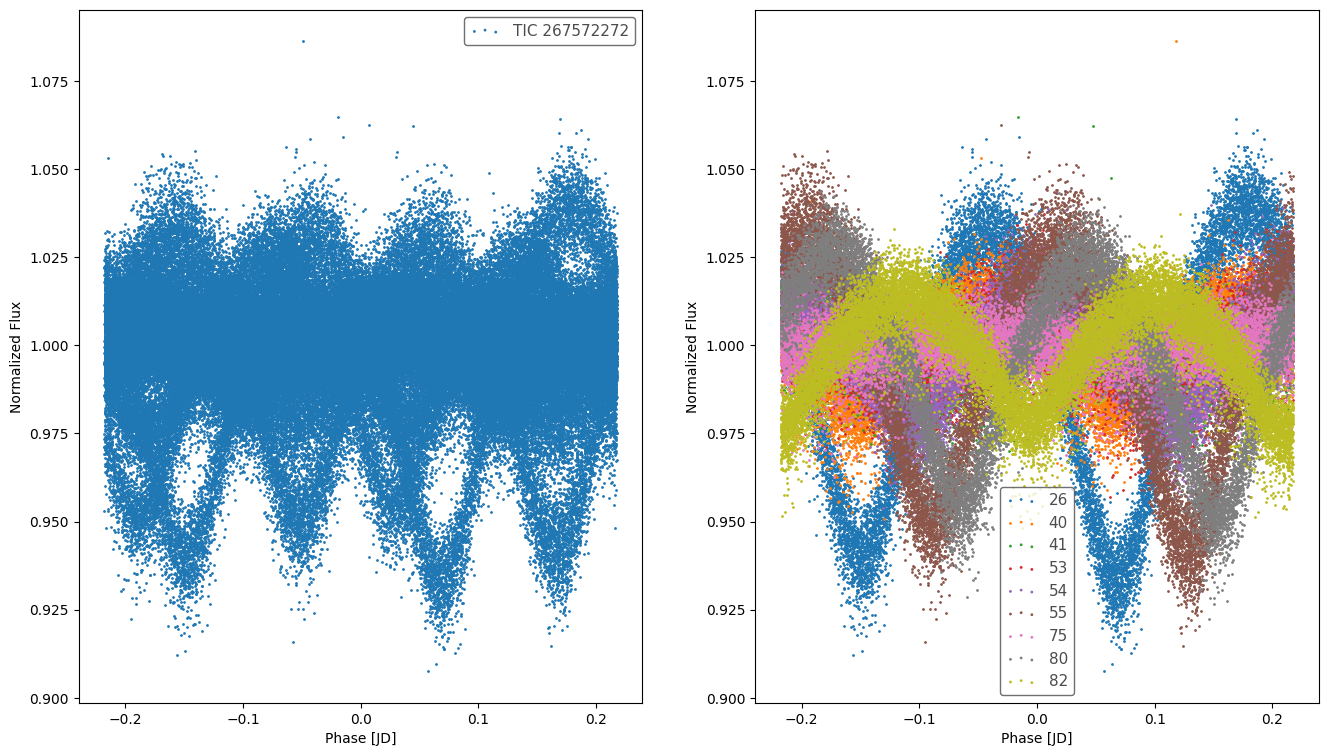

In [ ]:
# fold and plot each sector on top of one another
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
avg_folded_composite = composite_lc.fold(period=LS_EB_period)
avg_folded_composite.scatter(ax=ax1, normalize=True);
for lc in wellbehaving_list:
    folded_lc = lc.fold(period=LS_EB_period)
    folded_lc.scatter(ax=ax2, label=folded_lc.sector, normalize=True);

# NOTE: the final folded light curve from 4/7 experiments was only from ONE sector... need to find better way to align them

Now, we will test what the folded data looks like using Elisbeth's method (Box Least Squares). 

26 0.43543295219823086 d
40 0.4354553673725893 d
41 0.43550139798676607 d
53 0.43512650500162386 d
54 0.43541844674093144 d
55 0.43531218786071135 d
59 2.796216164491639 d
74 2.7978807389073808 d
75 2.795156352624111 d
80 0.43547521363969655 d
82 0.4354603146479749 d


Text(0.5, 0.98, 'EB period = 0.43539779818106555 d using 8.0 Sectors')

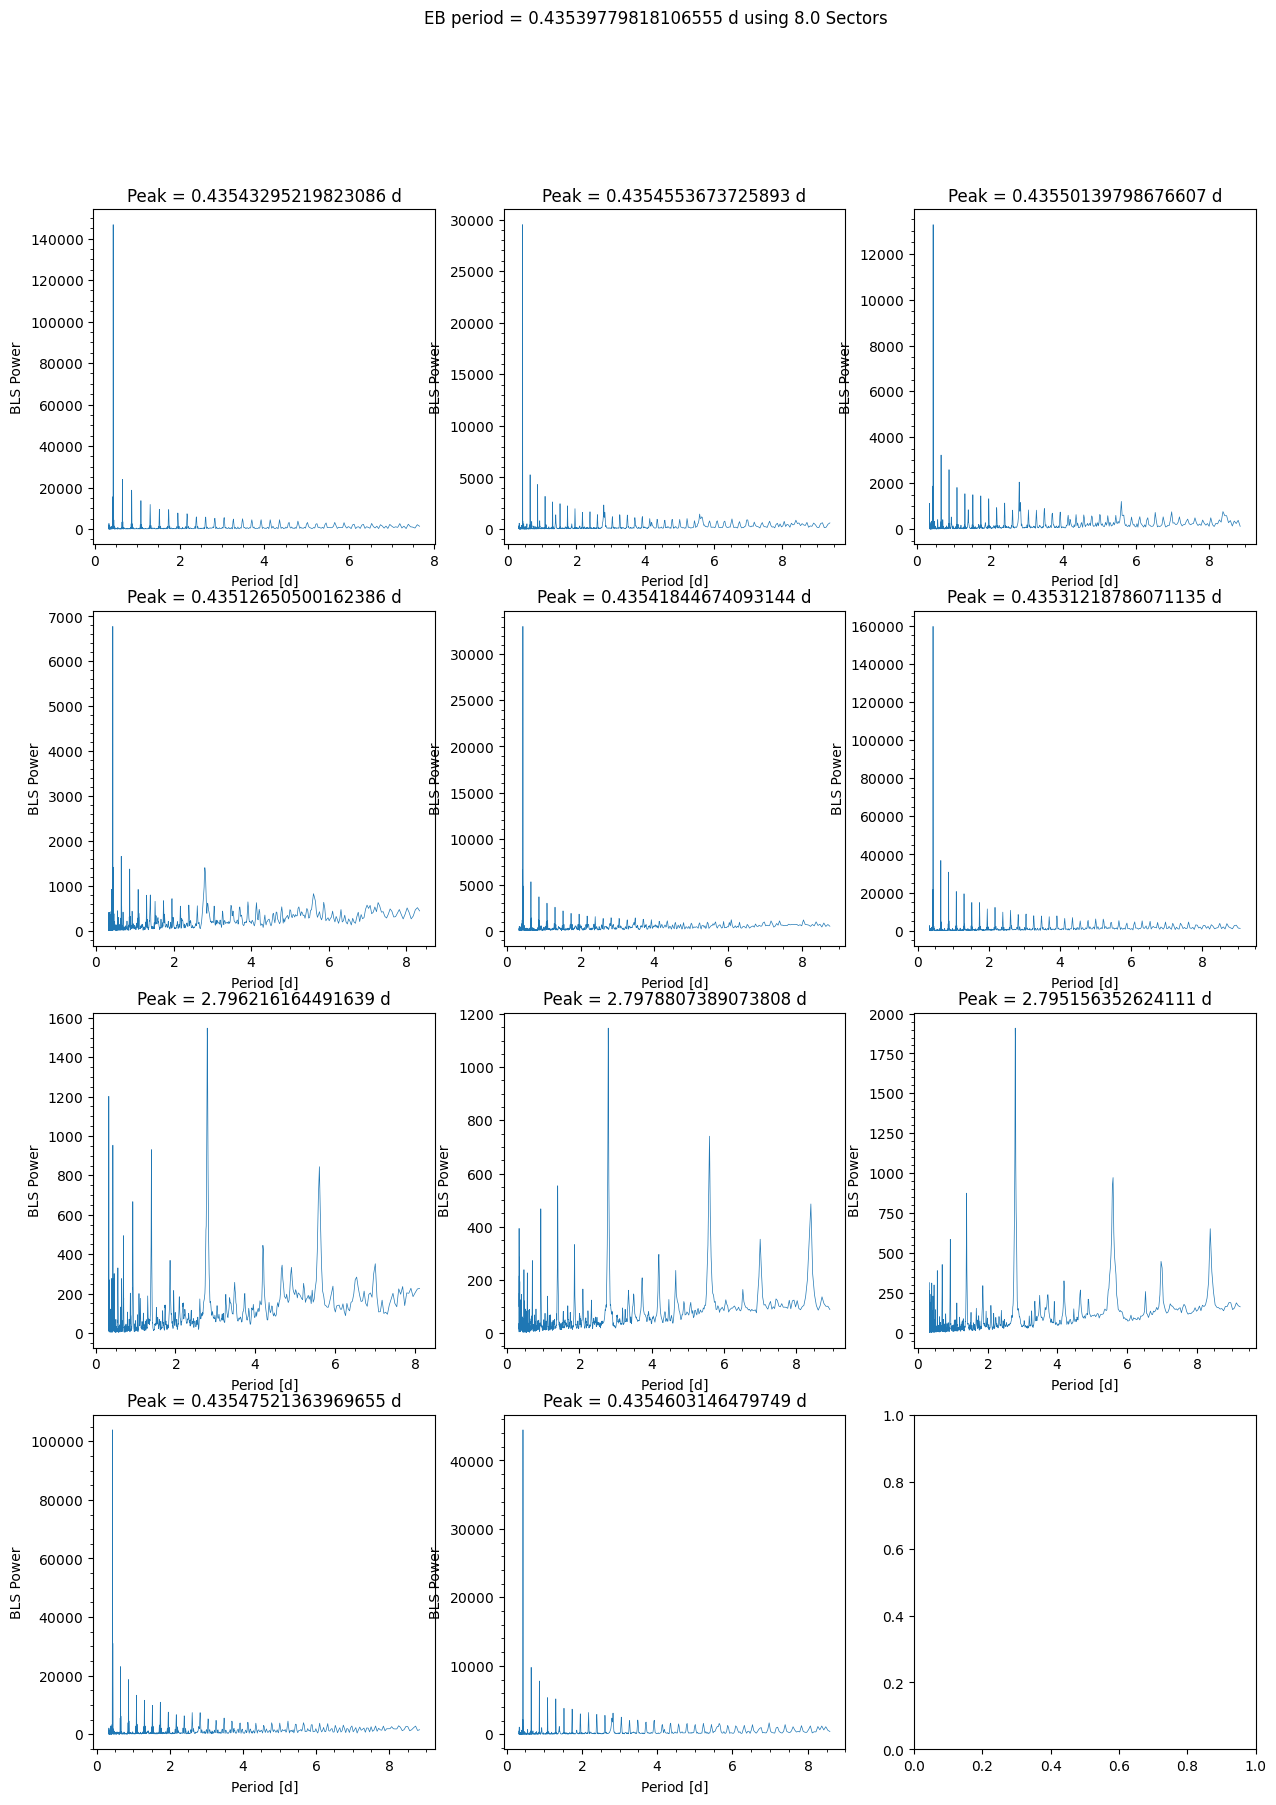

In [12]:
# Use the PDCSAP to calculate the LS for each sector of TESS data and plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
average_period = 0
BLS_list = []
for i, lc in enumerate([*tess_lc_collection]):
    pg = lc.to_periodogram(method="bls")
    pg.plot(ax=axs[ax_indices[i]])
    axs[ax_indices[i]].set_title(f"Peak = {pg.period_at_max_power}")
    axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.
    
    print(lc.sector, pg.period_at_max_power)
    if pg.period_at_max_power >= Quantity(1, "day"):  # do not include data that captures planet's period
        pass
    else:
        average_period += pg.period_at_max_power
        BLS_list.append(lc)
# after calculating the peakfor each sector, divde by number of sectors to get the average period
average_period /= len(BLS_list) 

# periods for each sector 
# 26 0.43543295219823086 d
# 40 0.4354553673725893 d
# 41 0.43550139798676607 d
# 53 0.43512650500162386 d
# 54 0.43541844674093144 d
# 55 0.43531218786071135 d
# 59 2.796216164491639 d
# 74 2.7978807389073808 d
# 75 2.795156352624111 d
# 80 0.43547521363969655 d
# 82 0.4354603146479749 d

# the box least squares plot pick sup on the full EB period, so we do not need to multiply it by 2
BLS_EB_period = average_period 
fig.suptitle(f"EB period = {BLS_EB_period} using {num_sectors_used} Sectors")

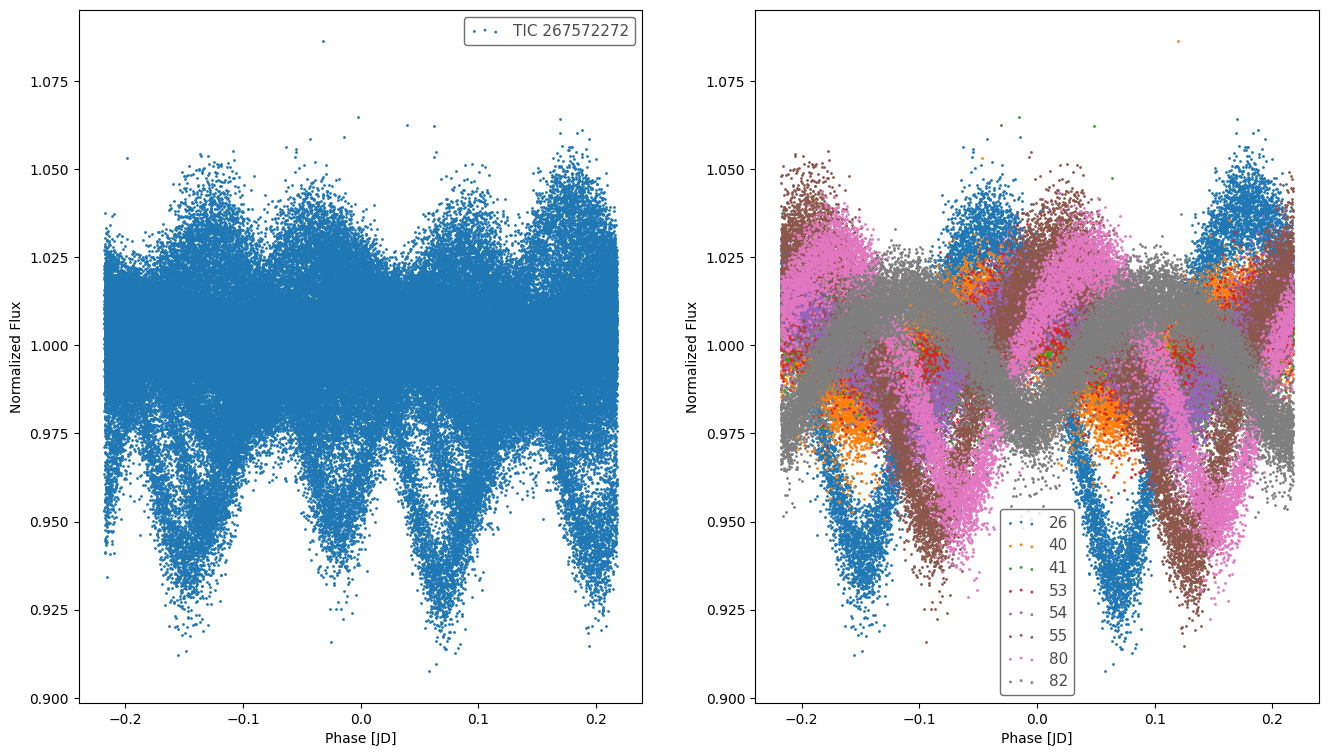

In [13]:
# fold and plot each sector on top of one another
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
bls_avg_folded_composite = composite_lc.fold(period=BLS_EB_period)
bls_avg_folded_composite.scatter(ax=ax1, normalize=True);
for lc in BLS_list:
    folded_lc = lc.fold(period=BLS_EB_period)
    folded_lc.scatter(ax=ax2, label=folded_lc.sector, normalize=True);

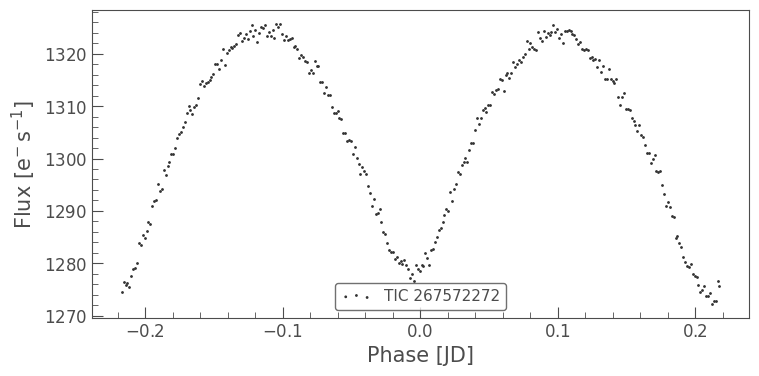

In [137]:
# Now we will calculate the binary eclipse function and de-trend using that.
binsize = 120./86400. # 120 seconds to days
binned_folded_lc = folded_lc.bin(binsize)
binned_folded_lc.scatter();

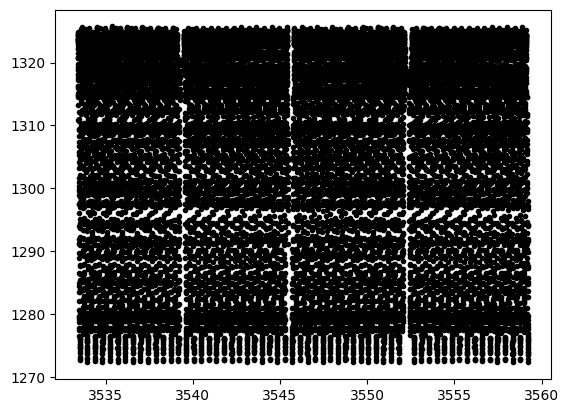

In [144]:
# Interpolate binned_folded_lc
time = big_lc.time.value
folded_time = big_lc.time.value % (2.*average_period.value)
mn_time = np.mean(folded_time)
interpolated_binned_folded_lc = np.interp(folded_time - mn_time, binned_folded_lc.time.value, binned_folded_lc.flux.value)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(time, interpolated_binned_folded_lc, marker='.', color='k')

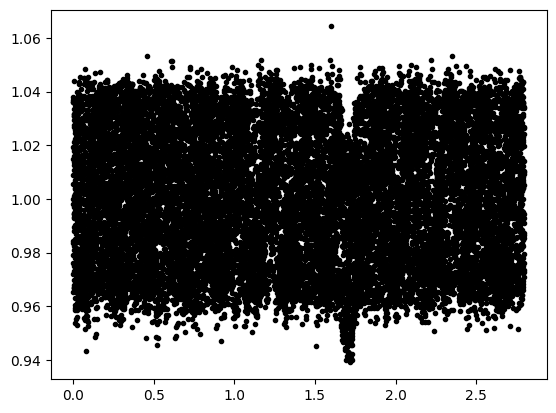

In [143]:
detrended_big_lc = big_lc.flux.value/interpolated_binned_folded_lc

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(big_lc.time.value % orbital_period, detrended_big_lc, marker='.', color='k')